## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import tensorflow.keras as keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
from sklearn import preprocessing

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
        x = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit_transform(x)
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from tensorflow.keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model


In [7]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [8]:
# 載入 Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau 

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.03,0.3,0.8]
redice_lr_patient = [5,10]

In [9]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    #####itertolls!!!!!
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)

#monitor: 被监测的数据。
#factor: 学习速率被降低的因数。新的学习速率 = 学习速率 * 因数
#patience: 没有进步的训练轮数，在这之后训练速率会被降低。
#verbose: 整数。0：安静，1：更新信息。
#mode: {auto, min, max} 其中之一。如果是 min 模式，学习速率会被降低如果被监测的数据已经停止下降；
#    在 max 模式，学习塑料会被降低如果被监测的数据已经停止上升； 在 auto 模式，方向会被从被监测的数据中自动推断出来。
#min_delta: 对于测量新的最优化的阀值，只关注巨大的改变。
#cooldown: 在学习速率被降低之后，重新恢复正常操作之前等待的训练轮数量。
#min_lr: 学习速率的下边界。
  
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.03, reduce_patient: 5
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
______________________________________________________________

Epoch 12/25
49/49 [==============================] - 4s 89ms/step - loss: 2.0154 - accuracy: 0.3128 - val_loss: 2.0262 - val_accuracy: 0.3023
Epoch 13/25
49/49 [==============================] - 4s 85ms/step - loss: 1.9925 - accuracy: 0.3190 - val_loss: 2.0085 - val_accuracy: 0.3065
Epoch 14/25
49/49 [==============================] - 5s 93ms/step - loss: 1.9702 - accuracy: 0.3238 - val_loss: 1.9915 - val_accuracy: 0.3096
Epoch 15/25
49/49 [==============================] - 4s 92ms/step - loss: 1.9513 - accuracy: 0.3286 - val_loss: 1.9757 - val_accuracy: 0.3135
Epoch 16/25
49/49 [==============================] - 4s 89ms/step - loss: 1.9334 - accuracy: 0.3346 - val_loss: 1.9609 - val_accuracy: 0.3171
Epoch 17/25
49/49 [==============================] - 4s 84ms/step - loss: 1.9166 - accuracy: 0.3392 - val_loss: 1.9472 - val_accuracy: 0.3213
Epoch 18/25
49/49 [==============================] - 4s 82ms/step - loss: 1.9023 - accuracy: 0.3433 - val_loss: 1.9343 - val_accuracy: 0.3258
Epoch 

Epoch 1/25
49/49 [==============================] - 4s 91ms/step - loss: 2.8614 - accuracy: 0.1263 - val_loss: 2.2962 - val_accuracy: 0.1328
Epoch 2/25
49/49 [==============================] - 4s 87ms/step - loss: 2.5972 - accuracy: 0.1731 - val_loss: 2.2404 - val_accuracy: 0.1717
Epoch 3/25
49/49 [==============================] - 4s 91ms/step - loss: 2.4390 - accuracy: 0.2052 - val_loss: 2.1952 - val_accuracy: 0.2017
Epoch 4/25
49/49 [==============================] - 5s 96ms/step - loss: 2.3389 - accuracy: 0.2302 - val_loss: 2.1621 - val_accuracy: 0.2269
Epoch 5/25
49/49 [==============================] - 4s 87ms/step - loss: 2.2656 - accuracy: 0.2488 - val_loss: 2.1419 - val_accuracy: 0.2447
Epoch 6/25
49/49 [==============================] - 4s 83ms/step - loss: 2.2078 - accuracy: 0.2633 - val_loss: 2.1296 - val_accuracy: 0.2591
Epoch 7/25
49/49 [==============================] - 4s 86ms/step - loss: 2.1631 - accuracy: 0.2736 - val_loss: 2.1193 - val_accuracy: 0.2689
Epoch 8/25
49

49/49 [==============================] - 4s 74ms/step - loss: 1.8558 - accuracy: 0.3573 - val_loss: 1.9070 - val_accuracy: 0.3434
Epoch 24/25
49/49 [==============================] - 4s 75ms/step - loss: 1.8441 - accuracy: 0.3613 - val_loss: 1.8983 - val_accuracy: 0.3459
Epoch 25/25
49/49 [==============================] - 3s 69ms/step - loss: 1.8342 - accuracy: 0.3638 - val_loss: 1.8901 - val_accuracy: 0.3479
Numbers of exp: 5, reduce_factor: 0.80, reduce_patient: 10
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_15 (Batc (None, 256)               1024      
__________________________________________

49/49 [==============================] - 6s 123ms/step - loss: 0.7572 - accuracy: 0.7395 - val_loss: 1.4379 - val_accuracy: 0.5239
Epoch 11/25
49/49 [==============================] - ETA: 0s - loss: 0.6923 - accuracy: 0.7616
Epoch 00011: ReduceLROnPlateau reducing learning rate to 3.0000001424923538e-05.
49/49 [==============================] - 9s 181ms/step - loss: 0.6923 - accuracy: 0.7616 - val_loss: 1.5310 - val_accuracy: 0.5149
Epoch 12/25
49/49 [==============================] - 5s 97ms/step - loss: 0.5552 - accuracy: 0.8224 - val_loss: 1.4286 - val_accuracy: 0.5345
Epoch 13/25
49/49 [==============================] - 5s 101ms/step - loss: 0.4905 - accuracy: 0.8538 - val_loss: 1.4267 - val_accuracy: 0.5412
Epoch 14/25
49/49 [==============================] - 4s 85ms/step - loss: 0.4677 - accuracy: 0.8651 - val_loss: 1.4319 - val_accuracy: 0.5443
Epoch 15/25
49/49 [==============================] - 4s 90ms/step - loss: 0.4523 - accuracy: 0.8712 - val_loss: 1.4386 - val_accuracy: 

Epoch 1/25
49/49 [==============================] - 4s 86ms/step - loss: 3.1075 - accuracy: 0.0955 - val_loss: 2.3698 - val_accuracy: 0.0950
Epoch 2/25
49/49 [==============================] - 5s 92ms/step - loss: 3.1082 - accuracy: 0.0962 - val_loss: 2.4219 - val_accuracy: 0.0893
Epoch 3/25
49/49 [==============================] - 5s 103ms/step - loss: 3.1078 - accuracy: 0.0958 - val_loss: 2.5054 - val_accuracy: 0.0889
Epoch 4/25
49/49 [==============================] - 5s 107ms/step - loss: 3.1085 - accuracy: 0.0947 - val_loss: 2.6118 - val_accuracy: 0.0879
Epoch 5/25
49/49 [==============================] - 5s 94ms/step - loss: 3.1074 - accuracy: 0.0955 - val_loss: 2.7263 - val_accuracy: 0.0911
Epoch 6/25
49/49 [==============================] - ETA: 0s - loss: 3.1076 - accuracy: 0.0953
Epoch 00006: ReduceLROnPlateau reducing learning rate to 7.289999853776763e-12.
49/49 [==============================] - 4s 90ms/step - loss: 3.1076 - accuracy: 0.0953 - val_loss: 2.8325 - val_accura

49/49 [==============================] - 4s 82ms/step - loss: 3.1912 - accuracy: 0.0857 - val_loss: 3.1645 - val_accuracy: 0.0849
Epoch 21/25
49/49 [==============================] - 3s 70ms/step - loss: 3.1918 - accuracy: 0.0851 - val_loss: 3.1647 - val_accuracy: 0.0849
Epoch 22/25
49/49 [==============================] - 4s 73ms/step - loss: 3.1924 - accuracy: 0.0856 - val_loss: 3.1647 - val_accuracy: 0.0849
Epoch 23/25
49/49 [==============================] - 4s 73ms/step - loss: 3.1920 - accuracy: 0.0849 - val_loss: 3.1648 - val_accuracy: 0.0849
Epoch 24/25
49/49 [==============================] - 4s 73ms/step - loss: 3.1932 - accuracy: 0.0854 - val_loss: 3.1649 - val_accuracy: 0.0850
Epoch 25/25
49/49 [==============================] - 4s 74ms/step - loss: 3.1912 - accuracy: 0.0861 - val_loss: 3.1648 - val_accuracy: 0.0849
Numbers of exp: 10, reduce_factor: 0.80, reduce_patient: 5
Model: "functional_21"
_________________________________________________________________
Layer (type)

49/49 [==============================] - 4s 75ms/step - loss: 2.9295 - accuracy: 0.1245 - val_loss: 2.7513 - val_accuracy: 0.1282
Epoch 8/25
49/49 [==============================] - 3s 70ms/step - loss: 2.9301 - accuracy: 0.1241 - val_loss: 2.8070 - val_accuracy: 0.1283
Epoch 9/25
49/49 [==============================] - 3s 71ms/step - loss: 2.9284 - accuracy: 0.1246 - val_loss: 2.8461 - val_accuracy: 0.1283
Epoch 10/25
49/49 [==============================] - 4s 82ms/step - loss: 2.9292 - accuracy: 0.1246 - val_loss: 2.8723 - val_accuracy: 0.1283
Epoch 11/25
49/49 [==============================] - 5s 100ms/step - loss: 2.9293 - accuracy: 0.1247 - val_loss: 2.8890 - val_accuracy: 0.1278
Epoch 12/25
49/49 [==============================] - 4s 73ms/step - loss: 2.9292 - accuracy: 0.1243 - val_loss: 2.8999 - val_accuracy: 0.1277
Epoch 13/25
49/49 [==============================] - 4s 74ms/step - loss: 2.9303 - accuracy: 0.1250 - val_loss: 2.9067 - val_accuracy: 0.1273
Epoch 14/25
49/49 [

Numbers of exp: 13, reduce_factor: 0.03, reduce_patient: 10
Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_39 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_40 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
___________________________________________________________

49/49 [==============================] - 5s 97ms/step - loss: 3.0760 - accuracy: 0.1010 - val_loss: 2.9874 - val_accuracy: 0.1026
Epoch 10/25
49/49 [==============================] - 5s 93ms/step - loss: 3.0765 - accuracy: 0.1011 - val_loss: 3.0170 - val_accuracy: 0.1027
Epoch 11/25
49/49 [==============================] - ETA: 0s - loss: 3.0757 - accuracy: 0.1010
Epoch 00011: ReduceLROnPlateau reducing learning rate to 2.1870000602164374e-12.
49/49 [==============================] - 5s 107ms/step - loss: 3.0757 - accuracy: 0.1010 - val_loss: 3.0360 - val_accuracy: 0.1029
Epoch 12/25
49/49 [==============================] - 5s 107ms/step - loss: 3.0765 - accuracy: 0.1004 - val_loss: 3.0480 - val_accuracy: 0.1026
Epoch 13/25
49/49 [==============================] - 5s 107ms/step - loss: 3.0760 - accuracy: 0.1000 - val_loss: 3.0555 - val_accuracy: 0.1031
Epoch 14/25
49/49 [==============================] - 5s 103ms/step - loss: 3.0761 - accuracy: 0.1009 - val_loss: 3.0602 - val_accuracy:

Epoch 1/25
49/49 [==============================] - 5s 111ms/step - loss: 2.8289 - accuracy: 0.1210 - val_loss: 2.2834 - val_accuracy: 0.1372
Epoch 2/25
49/49 [==============================] - 5s 105ms/step - loss: 2.8287 - accuracy: 0.1215 - val_loss: 2.3165 - val_accuracy: 0.1274
Epoch 3/25
49/49 [==============================] - 6s 115ms/step - loss: 2.8285 - accuracy: 0.1215 - val_loss: 2.3728 - val_accuracy: 0.1220
Epoch 4/25
49/49 [==============================] - 6s 117ms/step - loss: 2.8296 - accuracy: 0.1210 - val_loss: 2.4448 - val_accuracy: 0.1237
Epoch 5/25
49/49 [==============================] - 5s 111ms/step - loss: 2.8289 - accuracy: 0.1211 - val_loss: 2.5237 - val_accuracy: 0.1230
Epoch 6/25
49/49 [==============================] - 5s 96ms/step - loss: 2.8289 - accuracy: 0.1215 - val_loss: 2.5994 - val_accuracy: 0.1222
Epoch 7/25
49/49 [==============================] - 5s 112ms/step - loss: 2.8292 - accuracy: 0.1215 - val_loss: 2.6631 - val_accuracy: 0.1228
Epoch 8

49/49 [==============================] - 6s 117ms/step - loss: 3.1410 - accuracy: 0.0931 - val_loss: 3.1453 - val_accuracy: 0.0912
Epoch 24/25
49/49 [==============================] - 5s 102ms/step - loss: 3.1396 - accuracy: 0.0931 - val_loss: 3.1453 - val_accuracy: 0.0910
Epoch 25/25
49/49 [==============================] - 6s 118ms/step - loss: 3.1398 - accuracy: 0.0929 - val_loss: 3.1454 - val_accuracy: 0.0912


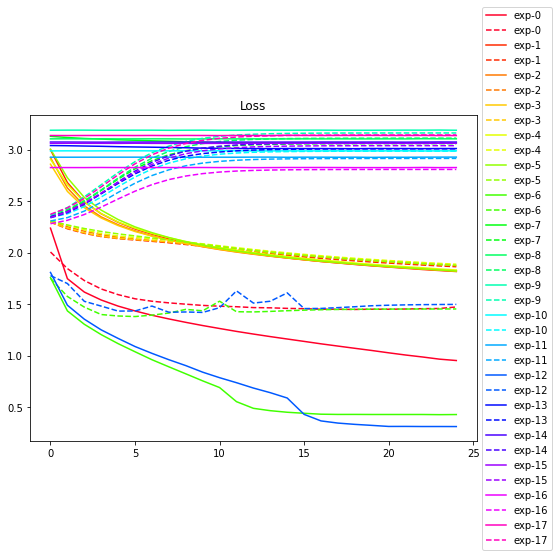

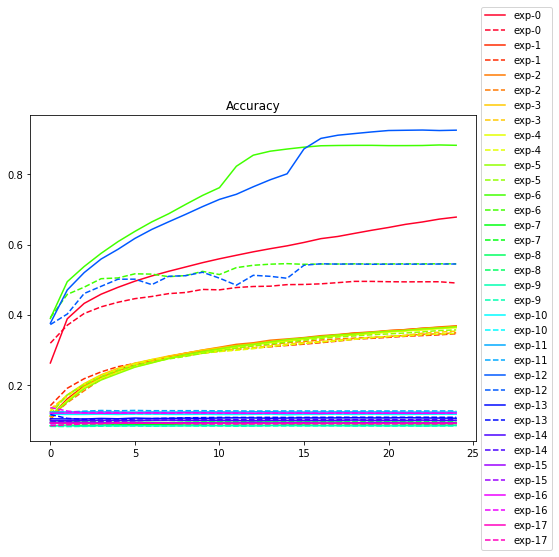

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

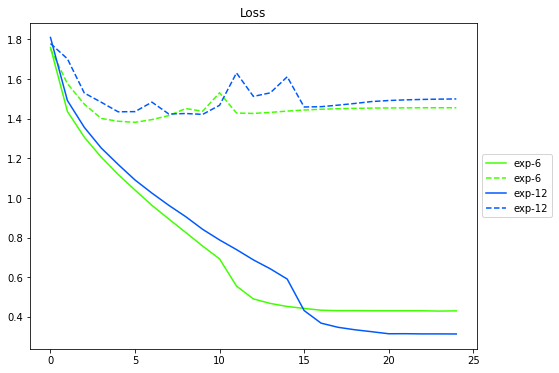

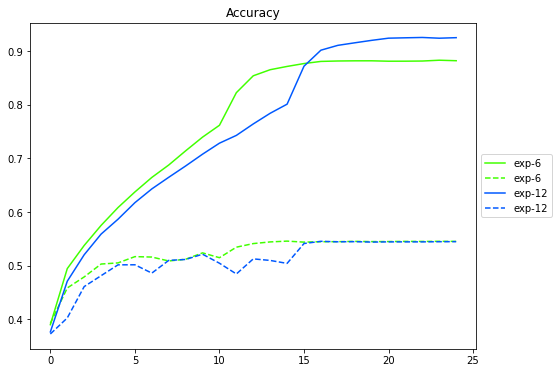

In [16]:
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    if results[cond]['train-acc'][-1]>0.8:
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
        
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    if results[cond]['train-acc'][-1]>0.8:
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
        
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [12]:
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    #####itertolls!!!!!
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i, optimizer: %s" % (i, reduce_factor, reduce_patient, optim))

Numbers of exp: 0, reduce_factor: 0.03, reduce_patient: 5, optimizer: <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f8575fb3450>
Numbers of exp: 1, reduce_factor: 0.03, reduce_patient: 10, optimizer: <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f8575fb3450>
Numbers of exp: 2, reduce_factor: 0.30, reduce_patient: 5, optimizer: <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f8575fb3450>
Numbers of exp: 3, reduce_factor: 0.30, reduce_patient: 10, optimizer: <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f8575fb3450>
Numbers of exp: 4, reduce_factor: 0.80, reduce_patient: 5, optimizer: <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f8575fb3450>
Numbers of exp: 5, reduce_factor: 0.80, reduce_patient: 10, optimizer: <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f8575fb3450>
Numbers of exp: 6, reduce_factor: 0.03, reduce_patient: 5, optimize